# Data Loading and Quality Control

This notebook performs initial data loading and exploratory data analysis (EDA) on the American Gut Project (AGP) dataset.

## Objectives:
- Load feature table, metadata, and taxonomy data
- Inspect data structure and dimensions
- Perform quality control checks
- Generate summary statistics
- Visualize key distributions

## 1. Import Libraries

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Polars display options
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(100)

polars.config.Config

## 2. Load Data Files

In [2]:
# Define data paths
data_dir = Path('../data/raw')
feature_table_path = data_dir / 'feature-table.tsv'
metadata_path = data_dir / 'metadata.tsv'
taxonomy_path = data_dir / 'taxonomy.tsv'

# Load data with Polars
print("Loading feature table...")
feature_table = pl.read_csv(feature_table_path, separator='\t')

print("Loading metadata...")
metadata = pl.read_csv(metadata_path, separator='\t')

print("Loading taxonomy...")
taxonomy = pl.read_csv(taxonomy_path, separator='\t')

print("\n✓ All data loaded successfully!")
print(f"\nMetadata shape: {metadata.shape}")
print(f"Feature table shape: {feature_table.shape}")
print(f"Taxonomy shape: {taxonomy.shape}")

Loading feature table...
Loading metadata...
Loading taxonomy...

✓ All data loaded successfully!

Metadata shape: (1000, 9)
Feature table shape: (500, 1001)
Taxonomy shape: (500, 2)


## 3. Metadata Exploratory Data Analysis

In [3]:
# Display basic metadata info
print("METADATA OVERVIEW")
print("=" * 70)
print(f"\nShape: {metadata.shape[0]} samples × {metadata.shape[1]} columns")
print(f"\nColumn names and types:")
print(metadata.schema)
print(f"\nFirst few rows:")
metadata.head()

METADATA OVERVIEW

Shape: 1000 samples × 9 columns

Column names and types:
Schema([('#SampleID', String), ('age', Int64), ('gender', String), ('country', String), ('sample_type', String), ('diet_type', String), ('coffee_consumption', String), ('antibiotics_past_year', String), ('bmi', Int64)])

First few rows:


#SampleID,age,gender,country,sample_type,diet_type,coffee_consumption,antibiotics_past_year,bmi
str,i64,str,str,str,str,str,str,i64
"""Sample_00000""",56,"""male""","""UK""","""Stool""","""Vegan""","""none""","""Yes""",30
"""Sample_00001""",69,"""male""","""USA""","""Stool""","""Vegan""","""occasional""","""Yes""",27
"""Sample_00002""",46,"""female""","""UK""","""Stool""","""Omnivore""","""occasional""","""No""",24
"""Sample_00003""",32,"""male""","""USA""","""Stool""","""Omnivore""","""occasional""","""No""",31
"""Sample_00004""",60,"""male""","""UK""","""Stool""","""Vegetarian""","""daily""","""Yes""",28


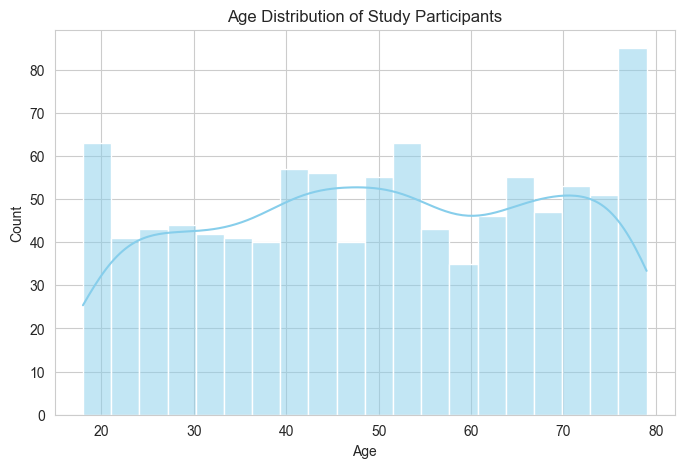

In [4]:
# Display distribution of age
plt.figure(figsize=(8, 5))
sns.histplot(metadata['age'].to_numpy(), bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Study Participants')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

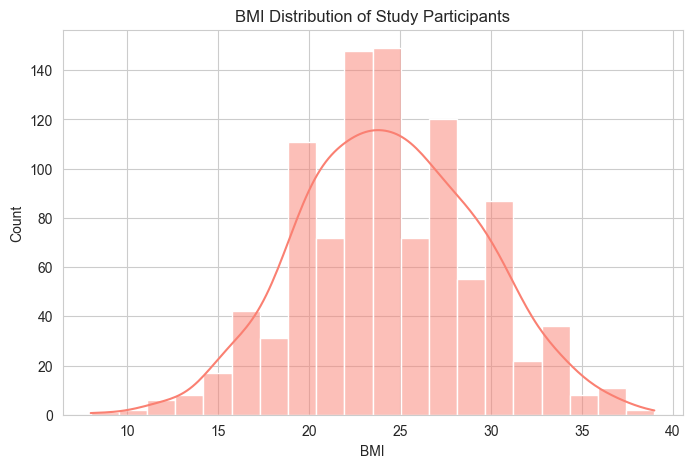

In [5]:
# display distribution of BMI
plt.figure(figsize=(8,5))
sns.histplot(metadata['bmi'].to_numpy(), bins=20, kde=True, color='salmon')
plt.title('BMI Distribution of Study Participants')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

In [6]:
# display unique values in categorical columns
categorical_cols = ['gender', 'country', 'sample_type', 'diet_type', 'coffee_consumption', 'antibiotics_past_year']
for col in categorical_cols:
    unique_values = metadata[col].unique().to_list()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'gender': ['male', 'female']
Unique values in 'country': ['Australia', 'UK', 'Canada', 'USA']
Unique values in 'sample_type': ['Stool']
Unique values in 'diet_type': ['Vegetarian', 'Omnivore', 'Vegan']
Unique values in 'coffee_consumption': ['occasional', 'daily', 'none']
Unique values in 'antibiotics_past_year': ['Yes', 'No']


## Taxonomy EDA

In [ ]:
# display columns of taxonomy table
print("\nTAXONOMY TABLE COLUMNS")
print("=" * 30)
print(taxonomy.columns)



TAXONOMY TABLE COLUMNS
['#OTU ID', 'Taxonomy']


In [11]:
# display head of taxonomy table
print("\nTAXONOMY OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows:")
taxonomy.head()


TAXONOMY OVERVIEW

First few rows:


#OTU ID,Taxonomy
str,str
"""OTU_0000""","""k__Bacteria;p__Bacteroidetes;c__Gammaproteobacteria;o__Bifidobacteriales;f__Enterobacteriaceae;g__Ba…"
"""OTU_0001""","""k__Bacteria;p__Actinobacteria;c__Bacteroidia;o__Clostridiales;f__Lachnospiraceae;g__Escherichia;s__c…"
"""OTU_0002""","""k__Bacteria;p__Firmicutes;c__Bacteroidia;o__Bifidobacteriales;f__Enterobacteriaceae;g__Roseburia;s__…"
"""OTU_0003""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Bifidobacteriales;f__Lachnospiraceae;g__Esch…"
"""OTU_0004""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Clostridiales;f__Bacteroidaceae;g__Roseburia…"


OTU stands for 'operational taxonomic units'. In layman terms, OTUs are clusters of DNA sequences that resemble closely-related bacteria. OTUs are thus a way to measure diversity in a population of bacteria, such as the microbiome. 

Taxonomy refers to a classification system that identifies which microorganisms 

In [16]:
# print size of taxonomy table
print(f"\nTaxonomy table size: {taxonomy.shape[0]} rows × {taxonomy.shape[1]} columns")


Taxonomy table size: 500 rows × 2 columns


In [22]:
# count taxonomy depths
taxonomy_depths = taxonomy['Taxonomy'].str.split(';').list.len()

# add taxonomy depths as a new column
taxonomy = taxonomy.with_columns(pl.Series(name='Taxonomy_Depth', values=taxonomy_depths))

# display new head 
print("\nTAXONOMY WITH DEPTH OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows with Taxonomy Depth:")
taxonomy.head()


TAXONOMY WITH DEPTH OVERVIEW

First few rows with Taxonomy Depth:


#OTU ID,Taxonomy,Taxonomy_Depth
str,str,u32
"""OTU_0000""","""k__Bacteria;p__Bacteroidetes;c__Gammaproteobacteria;o__Bifidobacteriales;f__Enterobacteriaceae;g__Ba…",7
"""OTU_0001""","""k__Bacteria;p__Actinobacteria;c__Bacteroidia;o__Clostridiales;f__Lachnospiraceae;g__Escherichia;s__c…",7
"""OTU_0002""","""k__Bacteria;p__Firmicutes;c__Bacteroidia;o__Bifidobacteriales;f__Enterobacteriaceae;g__Roseburia;s__…",7
"""OTU_0003""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Bifidobacteriales;f__Lachnospiraceae;g__Esch…",7
"""OTU_0004""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Clostridiales;f__Bacteroidaceae;g__Roseburia…",7


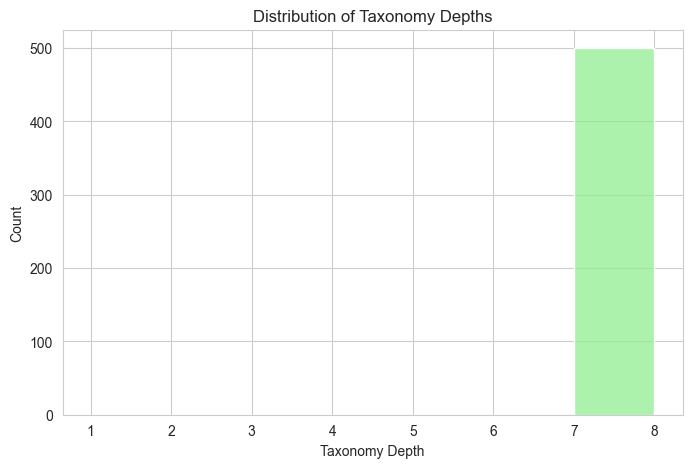

In [23]:
# display distribution of taxonomy depths
plt.figure(figsize=(8,5))
sns.histplot(taxonomy['Taxonomy_Depth'].to_numpy(), bins=range(1, taxonomy['Taxonomy_Depth'].max()+2), kde=False, color='lightgreen')
plt.title('Distribution of Taxonomy Depths')
plt.xlabel('Taxonomy Depth')
plt.ylabel('Count')
plt.show()

# Taxonomy Structure Summary

## Key Finding: All Organisms Have Exactly 7 Taxonomic Ranks

| Rank | Prefix | Example | Explanation |
|------|--------|---------|-------------|
| 1 | Kingdom (k__) | Bacteria | All microbes in AGP are bacteria |
| 2 | Phylum (p__) | Firmicutes | Major bacterial division |
| 3 | Class (c__) | Clostridia | Subdivision of phylum |
| 4 | Order (o__) | Clostridiales | Subdivision of class |
| 5 | Family (f__) | Lachnospiraceae | Subdivision of order |
| 6 | Genus (g__) | Roseburia | Subdivision of family |
| 7 | Species (s__) | faecalis | Most specific classification |

## Why the Distribution Makes Sense

**All rows have exactly 7 tokens because:**
- The American Gut Project uses **16S rRNA gene sequencing**, which follows the standard **Linnaean taxonomy** system
- Every organism is classified at all 7 ranks (kingdom → species) without exception
- This is a fixed biological classification standard, not variable data
- Therefore, when splitting taxonomy by `;`, you always get exactly 7 tokens